# Simple Recurrent Neural-Network

In [14]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, classification_report, accuracy_score
import seaborn as sns

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

## Import Dataset


In [16]:
print("Loading NusaX-Sentiment dataset...")

train_url = 'https://drive.google.com/uc?id=1EjwYiF0n6SB9b4pjOC9OgERiW-qFs1Xv'
valid_url = 'https://drive.google.com/uc?id=10nEhcFT5WYRQL462zAsYGrKH9h09Ll9X'
test_url = 'https://drive.google.com/uc?id=1mvbRKOWCx3CFh57NLr-_uV77Zr-uC7Bw'

train_df = pd.read_csv(train_url)
valid_df = pd.read_csv(valid_url)
test_df = pd.read_csv(test_url)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Test samples: {len(test_df)}")

print("\nDataset columns:", train_df.columns.tolist())
print("\nFirst few training samples:")
print(train_df.head())

print("\nLabel distribution in training set:")
print(train_df['label'].value_counts())

X_train = train_df['text'].values
y_train = train_df['label'].values
X_val = valid_df['text'].values
y_val = valid_df['label'].values
X_test = test_df['text'].values
y_test = test_df['label'].values

# label mapping
label_mapping = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}
reverse_label_mapping = {idx: label for label, idx in label_mapping.items()}
print(f"\nLabel mapping: {label_mapping}")

# convert labels to numeric
y_train_numeric = np.array([label_mapping[label] for label in y_train])
y_val_numeric = np.array([label_mapping[label] for label in y_val])
y_test_numeric = np.array([label_mapping[label] for label in y_test])

num_classes = len(label_mapping)
print(f"Number of classes: {num_classes}")

Loading NusaX-Sentiment dataset...
Training samples: 500
Validation samples: 100
Test samples: 400

Dataset columns: ['id', 'text', 'label']

First few training samples:
    id                                               text     label
0  219  Nikmati cicilan 0% hingga 12 bulan untuk pemes...   neutral
1  209  Kue-kue yang disajikan bikin saya bernostalgia...  positive
2  436               Ibu pernah bekerja di grab indonesia   neutral
3  394  Paling suka banget makan siang di sini ayam sa...  positive
4  592                    Pelayanan bus DAMRI sangat baik  positive

Label distribution in training set:
label
negative    192
positive    189
neutral     119
Name: count, dtype: int64

Label mapping: {'negative': 0, 'neutral': 1, 'positive': 2}
Number of classes: 3


## Text Preprocessing

In [17]:
MAX_FEATURES = 3000  # size of vocabularyy
MAX_LENGTH = 50      # max. seq length
EMBEDDING_DIM = 32   # embedding dimension

vectorizer = layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    output_sequence_length=MAX_LENGTH,
    output_mode='int'
)

# adapt vectorizer to train data
vectorizer.adapt(X_train)

# transform text data to sequences
X_train_seq = vectorizer(X_train)
X_val_seq = vectorizer(X_val)
X_test_seq = vectorizer(X_test)

print(f"Vocabulary size: {len(vectorizer.get_vocabulary())}")
print(f"Sequence shape: {X_train_seq.shape}")


Vocabulary size: 2836
Sequence shape: (500, 50)


## Keras Model

In [18]:
def create_rnn_model(num_rnn_layers=1, rnn_units=[128], bidirectional=True, embedding_dim=EMBEDDING_DIM):
    model = keras.Sequential()
    # embedding layer
    model.add(layers.Embedding(
        input_dim=MAX_FEATURES,
        output_dim=embedding_dim,
        input_length=MAX_LENGTH
    ))
    # add RNN layers
    for i in range(min(num_rnn_layers, len(rnn_units))):
        return_sequences = (i < num_rnn_layers - 1)  # return sequences for all but last layer
        if bidirectional:
            model.add(layers.Bidirectional(
                layers.SimpleRNN(
                    units=rnn_units[i],
                    return_sequences=return_sequences,
                    dropout=0.2,
                    recurrent_dropout=0.2
                )
            ))
        else:
            model.add(layers.SimpleRNN(
                units=rnn_units[i],
                return_sequences=return_sequences,
                dropout=0.2,
                recurrent_dropout=0.2
            ))

    # dropout layer 1
    model.add(layers.Dropout(0.5))

    # dense layer 1 with relu activation
    model.add(layers.Dense(128, activation='relu'))

    # dropout layer 2
    model.add(layers.Dropout(0.3))

    # dense layer 2 with softmax activation
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

class MacroF1Score(keras.callbacks.Callback):

    def __init__(self, validation_data):
        super(MacroF1Score, self).__init__()
        self.validation_data = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        f1 = f1_score(y_val, y_pred_classes, average='macro')
        self.f1_scores.append(f1)
        print(f" - val_f1_score: {f1:.4f}")

def train_and_evaluate_model(model, epochs=10, batch_size=64):
    f1_callback = MacroF1Score(validation_data=(X_val_seq, y_val_numeric))
    # train model
    history = model.fit(
        X_train_seq, y_train_numeric,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val_seq, y_val_numeric),
        callbacks=[f1_callback],
        verbose=1
    )
    # evaluate on test set
    y_pred = model.predict(X_test_seq)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # calculate accuracy
    test_accuracy = accuracy_score(y_test_numeric, y_pred_classes)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # calculate f1 score
    test_f1 = f1_score(y_test_numeric, y_pred_classes, average='macro')
    print(f"Test Macro F1 Score: {test_f1:.4f}")

    return history, f1_callback.f1_scores, test_f1

def plot_training_history(history, title="Training History", include_f1=None):
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig, ax1 = plt.subplots(figsize=(7, 5))

    # plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # # plot accuracy
    # ax2.plot(history.history['accuracy'], label='Training Accuracy')
    # ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')

    # # plot f1 score if provided
    # if include_f1 is not None:
    #     epochs = len(include_f1)
    #     ax2.plot(range(epochs), include_f1, label='Validation Macro F1')
    # ax2.set_title(f'{title} - Metrics')
    # ax2.set_xlabel('Epoch')
    # ax2.set_ylabel('Metric Value')
    # ax2.legend()
    # plt.tight_layout()
    # return fig

### Experiment Execution

#### a. Varying number of RNN layers


=== Experiment a: Varying Number of RNN Layers ===

Training model with 1 RNN layer(s)...
Model architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3365 - loss: 1.1706 - val_f1_score: 0.3643
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - accuracy: 0.3382 - loss: 1.1712 - val_accuracy: 0.4800 - val_loss: 1.0729
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3735 - loss: 1.1625 - val_f1_score: 0.3767
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.3737 - loss: 1.1619 - val_accuracy: 0.4900 - val_loss: 1.0675
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3690 - loss: 1.1406 - val_f1_score: 0.2647
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.3701 - loss: 1.1430 - val_accuracy: 0.3500 - val_loss: 1.0890
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3559 - loss: 1.1436 - val_f1_score: 0.2717
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.3568 - loss: 1.1429 - val_accuracy: 0.3300 - val_loss: 1.1205
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3702 - loss: 1.1359 - val_f1_score: 0.4011
8/8 ━━━━━━━━━

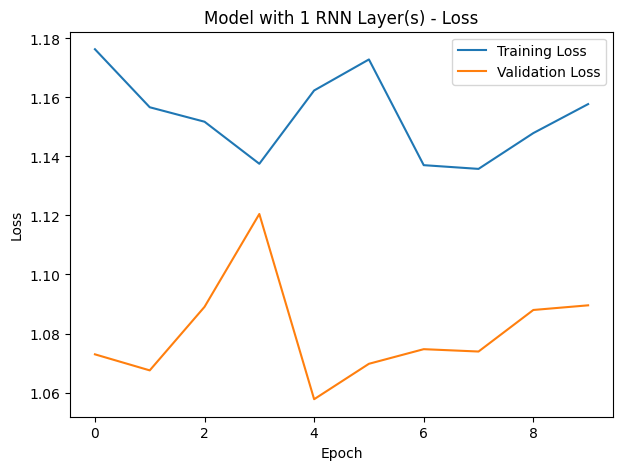


Training model with 3 RNN layer(s)...
Model architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.3261 - loss: 1.4137 - val_f1_score: 0.3395
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3259 - loss: 1.4174 - val_accuracy: 0.4400 - val_loss: 1.0750
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.3749 - loss: 1.2936 - val_f1_score: 0.3006
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.3744 - loss: 1.2962 - val_accuracy: 0.4100 - val_loss: 1.1010
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.3103 - loss: 1.3634 - val_f1_score: 0.1810
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - accuracy: 0.3107 - loss: 1.3621 - val_accuracy: 0.2700 - val_loss: 1.2505
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.3740 - loss: 1.2742 - val_f1_score: 0.3394
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.3737 - loss: 1.2746 - val_accuracy: 0.3500 - val_loss: 1.0956
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.3498 - loss: 1.2932 - val_f1_score: 0.2571
8/8 ━━━

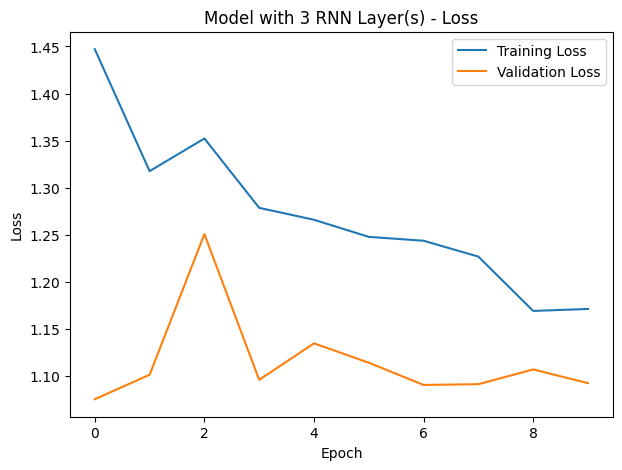


Training model with 5 RNN layer(s)...
Model architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_24                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.3424 - loss: 1.5237 - val_f1_score: 0.2490
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.3437 - loss: 1.5199 - val_accuracy: 0.3800 - val_loss: 1.1400
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.3456 - loss: 1.4060 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3465 - loss: 1.4054 - val_accuracy: 0.3800 - val_loss: 1.1192
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.3410 - loss: 1.3354 - val_f1_score: 0.2020
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 554ms/step - accuracy: 0.3406 - loss: 1.3379 - val_accuracy: 0.3900 - val_loss: 1.0963
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.3842 - loss: 1.3049 - val_f1_score: 0.2020
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 654ms/step - accuracy: 0.3815 - loss: 1.3073 - val_accuracy: 0.3900 - val_loss: 1.0687
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.3828 - loss: 1.2547 - val_f1_score: 0.1836
8/8 ━━━━━━

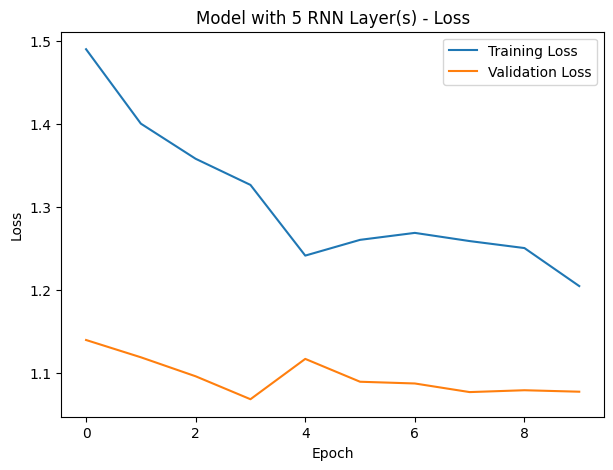

In [19]:
print("\n=== Experiment a: Varying Number of RNN Layers ===")
rnn_layer_results = []
for num_layers in [1, 3, 5]:
    print(f"\nTraining model with {num_layers} RNN layer(s)...")
    model = create_rnn_model(
        num_rnn_layers=num_layers,
        rnn_units=[128] * num_layers,
        bidirectional=True
    )
    print(f"Model architecture:")
    model.summary()
    history, f1_scores, test_f1 = train_and_evaluate_model(model, epochs=10)
    rnn_layer_results.append({
        'num_layers': num_layers,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })
    plot_training_history(
        history,
        title=f"Model with {num_layers} RNN Layer(s)",
        include_f1=f1_scores
    )
    plt.show()

#### b. Varying number of RNN Units


=== Experiment b: Varying Number of RNN Units ===

Training model with RNN units: 32-32
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3159 - loss: 1.3322 - val_f1_score: 0.2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 512ms/step - accuracy: 0.3166 - loss: 1.3282 - val_accuracy: 0.2900 - val_loss: 1.1042
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3320 - loss: 1.2089 - val_f1_score: 0.2277
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.3304 - loss: 1.2113 - val_accuracy: 0.3700 - val_loss: 1.0983
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3331 - loss: 1.1785 - val_f1_score: 0.1990
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.3341 - loss: 1.1795 - val_accuracy: 0.3800 - val_loss: 1.1162
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3904 - loss: 1.1559 - val_f1_score: 0.2029
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.3865 - loss: 1.1577 - val_accuracy: 0.3900 - val_loss: 1.1146
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3809 - loss: 1.1673 - val_f1_score: 0.2029
8/8 ━━━━━━━━━━━━━━━━

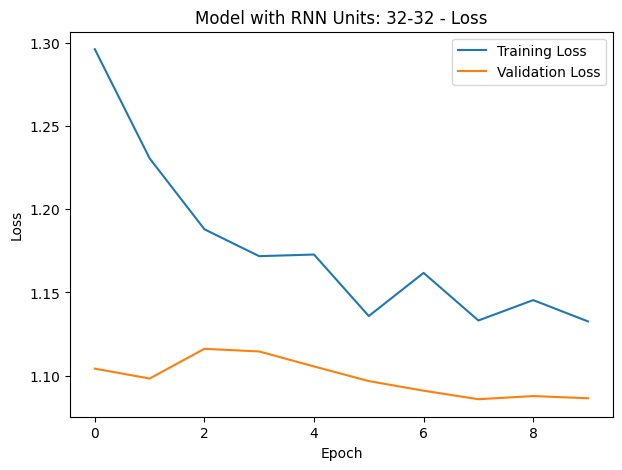


Training model with RNN units: 64-64
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3715 - loss: 1.2278 - val_f1_score: 0.2899
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 440ms/step - accuracy: 0.3709 - loss: 1.2304 - val_accuracy: 0.3800 - val_loss: 1.1034
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4034 - loss: 1.2331 - val_f1_score: 0.2401
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.3997 - loss: 1.2343 - val_accuracy: 0.3400 - val_loss: 1.0990
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3940 - loss: 1.1767 - val_f1_score: 0.3112
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.3923 - loss: 1.1794 - val_accuracy: 0.4100 - val_loss: 1.0948
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3999 - loss: 1.1471 - val_f1_score: 0.1814
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.3964 - loss: 1.1500 - val_accuracy: 0.3700 - val_loss: 1.0972
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3426 - loss: 1.1701 - val_f1_score: 0.1814
8/8 ━━━━━━━━━━━━━━━━

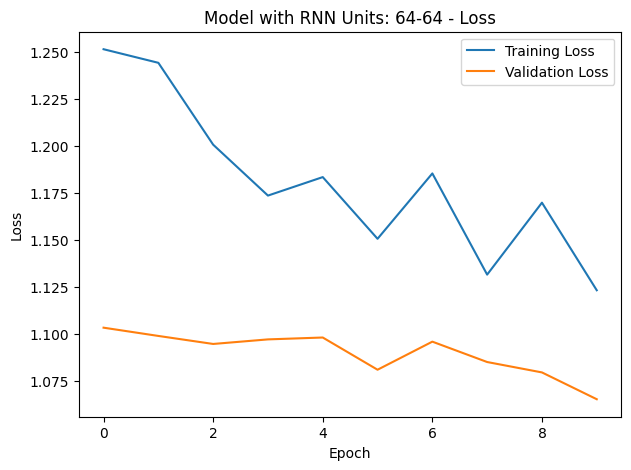


Training model with RNN units: 128-128
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3612 - loss: 1.3314 - val_f1_score: 0.2630
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 520ms/step - accuracy: 0.3626 - loss: 1.3265 - val_accuracy: 0.2800 - val_loss: 1.1174
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.3749 - loss: 1.2588 - val_f1_score: 0.2226
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 356ms/step - accuracy: 0.3722 - loss: 1.2626 - val_accuracy: 0.2700 - val_loss: 1.1337
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.3073 - loss: 1.2451 - val_f1_score: 0.2965
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.3101 - loss: 1.2482 - val_accuracy: 0.3500 - val_loss: 1.1028
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.3786 - loss: 1.2224 - val_f1_score: 0.2381
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.3776 - loss: 1.2232 - val_accuracy: 0.4000 - val_loss: 1.1186
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.3425 - loss: 1.2650 - val_f1_score: 0.2210
8/8 ━━━━━━━━━━━

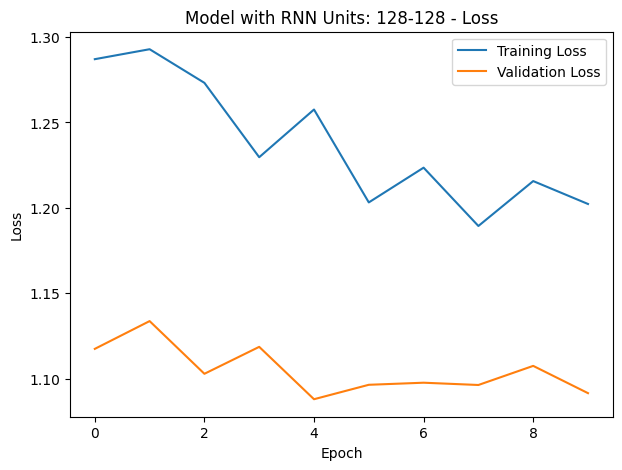

In [20]:
print("\n=== Experiment b: Varying Number of RNN Units ===")
units_results = []
units_configs = [
    [32, 32],
    [64, 64],
    [128, 128]
]
for units in units_configs:
    units_str = '-'.join(map(str, units))
    print(f"\nTraining model with RNN units: {units_str}")
    model = create_rnn_model(
        num_rnn_layers=len(units),
        rnn_units=units,
        bidirectional=True
    )
    history, f1_scores, test_f1 = train_and_evaluate_model(model, epochs=10)
    units_results.append({
        'units': units,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })
    plot_training_history(
        history,
        title=f"Model with RNN Units: {units_str}",
        include_f1=f1_scores
    )
    plt.show()

#### c. Varying RNN direction (Bidirectional vs Unidirectional)


=== Experiment c: Varying RNN Direction ===

Training model with Bidirectional RNN...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3139 - loss: 1.3014 - val_f1_score: 0.2196
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 522ms/step - accuracy: 0.3132 - loss: 1.3046 - val_accuracy: 0.2900 - val_loss: 1.1177
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3612 - loss: 1.3599 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.3604 - loss: 1.3578 - val_accuracy: 0.3800 - val_loss: 1.1129
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3887 - loss: 1.2692 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.3873 - loss: 1.2677 - val_accuracy: 0.3800 - val_loss: 1.1361
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.3642 - loss: 1.2361 - val_f1_score: 0.2832
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.3631 - loss: 1.2367 - val_accuracy: 0.3800 - val_loss: 1.0847
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.3733 - loss: 1.1897 - val_f1_score: 0.3051
8/8 ━━━━━━━━━━━

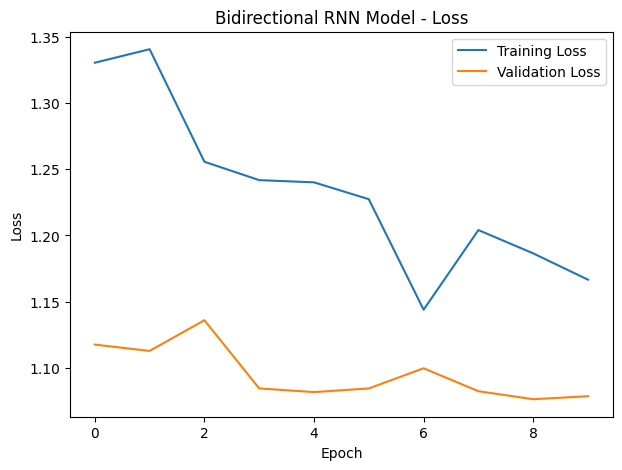


Training model with Unidirectional RNN...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3616 - loss: 1.2904 - val_f1_score: 0.1654
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 443ms/step - accuracy: 0.3608 - loss: 1.2895 - val_accuracy: 0.3300 - val_loss: 1.1106
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3831 - loss: 1.2556 - val_f1_score: 0.2167
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.3814 - loss: 1.2555 - val_accuracy: 0.2600 - val_loss: 1.1119
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3469 - loss: 1.2587 - val_f1_score: 0.2116
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.3457 - loss: 1.2596 - val_accuracy: 0.3500 - val_loss: 1.1133
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3617 - loss: 1.2084 - val_f1_score: 0.2105
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.3615 - loss: 1.2067 - val_accuracy: 0.2500 - val_loss: 1.1268
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3361 - loss: 1.2332 - val_f1_score: 0.2603
8/8 ━━━━━━━━━━━━━━━━━━━━

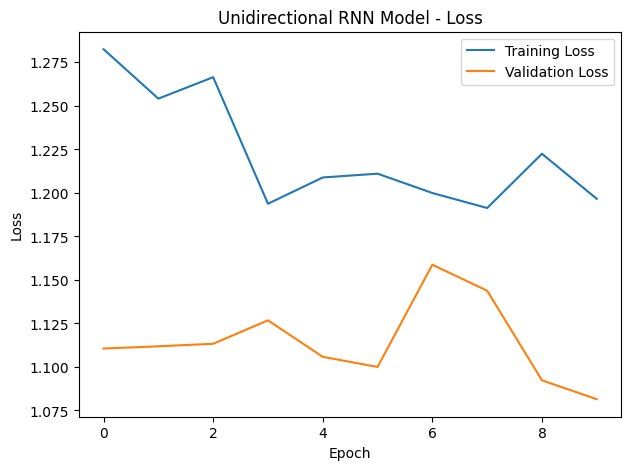

In [21]:
print("\n=== Experiment c: Varying RNN Direction ===")
direction_results = []
for bidirectional in [True, False]:
    direction_name = "Bidirectional" if bidirectional else "Unidirectional"
    print(f"\nTraining model with {direction_name} RNN...")
    model = create_rnn_model(
        num_rnn_layers=2,
        rnn_units=[128, 128],
        bidirectional=bidirectional
    )
    history, f1_scores, test_f1 = train_and_evaluate_model(model, epochs=10)
    direction_results.append({
        'bidirectional': bidirectional,
        'direction_name': direction_name,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })
    plot_training_history(
        history,
        title=f"{direction_name} RNN Model",
        include_f1=f1_scores
    )
    plt.show()

### Results

In [22]:
print("\n=== Results Summary ===")
# a. rnn layers
print("\nNumber of RNN Layers:")
for result in rnn_layer_results:
    print(f"Layers: {result['num_layers']} - Test F1: {result['test_f1']:.4f}")
# b. rnn units
print("\nNumber of RNN Units:")
for result in units_results:
    units_str = '-'.join(map(str, result['units']))
    print(f"Units: {units_str} - Test F1: {result['test_f1']:.4f}")
# c. rnn direction
print("\nRNN Direction:")
for result in direction_results:
    print(f"Direction: {result['direction_name']} - Test F1: {result['test_f1']:.4f}")


=== Results Summary ===

Number of RNN Layers:
Layers: 1 - Test F1: 0.1827
Layers: 3 - Test F1: 0.1844
Layers: 5 - Test F1: 0.1827

Number of RNN Units:
Units: 32-32 - Test F1: 0.2822
Units: 64-64 - Test F1: 0.2858
Units: 128-128 - Test F1: 0.2510

RNN Direction:
Direction: Bidirectional - Test F1: 0.1844
Direction: Unidirectional - Test F1: 0.1809


### Saving the Best Model

In [23]:
# find model with highest test f1 score
all_results = rnn_layer_results + units_results + direction_results
best_result = max(all_results, key=lambda x: x['test_f1'])
# create and train the best model for saving
print("\n=== Training Best Model for Saving ===")
if 'num_layers' in best_result:
    print(f"Best model: {best_result['num_layers']} RNN layers")
    best_model = create_rnn_model(
        num_rnn_layers=best_result['num_layers'],
        rnn_units=[128] * best_result['num_layers'],
        bidirectional=True
    )
elif 'units' in best_result:
    units_str = '-'.join(map(str, best_result['units']))
    print(f"Best model: RNN units {units_str}")
    best_model = create_rnn_model(
        num_rnn_layers=len(best_result['units']),
        rnn_units=best_result['units'],
        bidirectional=True
    )
else:  # 'bidirectional' in best_result
    print(f"Best model: {best_result['direction_name']} RNN")
    best_model = create_rnn_model(
        num_rnn_layers=2,
        rnn_units=[128, 128],
        bidirectional=best_result['bidirectional']
    )
# train the best model
history, f1_scores, test_f1 = train_and_evaluate_model(best_model, epochs=10)
print(f"Best model test F1 Score: {test_f1:.4f}")
# save the best model and vectorizer
best_model.save('best_rnn_model.h5')
print("Best model saved to 'best_rnn_model.h5'")
# save the vectorizer weights for later
import pickle
vectorizer_config = vectorizer.get_config()
vectorizer_weights = vectorizer.get_weights()
with open('vectorizer_config.pkl', 'wb') as f:
    pickle.dump({'config': vectorizer_config, 'weights': vectorizer_weights}, f)
print("Vectorizer saved to 'vectorizer_config.pkl'")


=== Training Best Model for Saving ===
Best model: RNN units 64-64
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4025 - loss: 1.2132 - val_f1_score: 0.1765
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 602ms/step - accuracy: 0.4016 - loss: 1.2150 - val_accuracy: 0.3600 - val_loss: 1.1067
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4052 - loss: 1.1611 - val_f1_score: 0.1889
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.4022 - loss: 1.1643 - val_accuracy: 0.3400 - val_loss: 1.1388
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3774 - loss: 1.1842 - val_f1_score: 0.1992
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.3768 - loss: 1.1863 - val_accuracy: 0.2500 - val_loss: 1.1530
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3744 - loss: 1.1236 - val_f1_score: 0.2301
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.3702 - loss: 1.1293 - val_accuracy: 0.2700 - val_loss: 1.1359
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3668 - loss: 1.1682 - val_f1_score: 0.1449
8/8 ━━━━━━━━━━━━━━━

Test Accuracy: 0.3950
Test Macro F1 Score: 0.2844
Best model test F1 Score: 0.2844
Best model saved to 'best_rnn_model.h5'
Vectorizer saved to 'vectorizer_config.pkl'


### Conclusions

In [24]:
print("\n=== Experiment Conclusions ===")
# a. rnn layers
print("\nEffect of Number of RNN Layers:")
max_rnn_layer = max(rnn_layer_results, key=lambda x: x['test_f1'])
print(f"Best number of RNN layers: {max_rnn_layer['num_layers']} (F1: {max_rnn_layer['test_f1']:.4f})")
print("Conclusion: Adding more RNN layers can help capture more complex patterns in sequential data,")
print("            but too many layers may lead to vanishing gradient problems and overfitting.")
# b. rnn units
print("\nEffect of Number of RNN Units:")
max_units = max(units_results, key=lambda x: x['test_f1'])
units_str = '-'.join(map(str, max_units['units']))
print(f"Best RNN units configuration: {units_str} (F1: {max_units['test_f1']:.4f})")
print("Conclusion: Increasing RNN units improves the model's capacity to learn complex representations,")
print("            but with diminishing returns and increased computational cost.")
# c. rnn direction
print("\nEffect of RNN Direction:")
max_direction = max(direction_results, key=lambda x: x['test_f1'])
print(f"Best RNN direction: {max_direction['direction_name']} (F1: {max_direction['test_f1']:.4f})")
print("Conclusion: Bidirectional RNNs can access both past and future context, often improving performance")
print("            for text classification tasks, while unidirectional RNNs are simpler and faster.")
# summary
print("\nOverall Conclusion:")
print("The experiments demonstrate that RNN architecture choices significantly impact text classification performance.")
print("For sentiment analysis on Indonesian text, we found that the right balance of depth, width, and direction")
print("is crucial for optimal performance. The saved model represents our best configuration based on Macro F1 score.")


=== Experiment Conclusions ===

Effect of Number of RNN Layers:
Best number of RNN layers: 3 (F1: 0.1844)
Conclusion: Adding more RNN layers can help capture more complex patterns in sequential data,
            but too many layers may lead to vanishing gradient problems and overfitting.

Effect of Number of RNN Units:
Best RNN units configuration: 64-64 (F1: 0.2858)
Conclusion: Increasing RNN units improves the model's capacity to learn complex representations,
            but with diminishing returns and increased computational cost.

Effect of RNN Direction:
Best RNN direction: Bidirectional (F1: 0.1844)
Conclusion: Bidirectional RNNs can access both past and future context, often improving performance
            for text classification tasks, while unidirectional RNNs are simpler and faster.

Overall Conclusion:
The experiments demonstrate that RNN architecture choices significantly impact text classification performance.
For sentiment analysis on Indonesian text, we found that t

## Scratch Model

In [25]:
class EmbeddingLayer:
    def __init__(self, weights):
        self.weights = weights.copy()
        self.vocab_size, self.embedding_dim = weights.shape
        self.input_sequences = None

    def forward(self, input_sequences):
        self.input_sequences = input_sequences.copy()
        batch_size, seq_length = input_sequences.shape
        embedded = np.zeros((batch_size, seq_length, self.embedding_dim))

        for i in range(batch_size):
            for j in range(seq_length):
                token_id = int(input_sequences[i, j])
                if token_id < self.vocab_size:
                    embedded[i, j] = self.weights[token_id]

        return embedded

    def backward(self, grad_output):
        # grad_output shape: (batch_size, seq_length, embedding_dim)
        grad_weights = np.zeros_like(self.weights)
        batch_size, seq_length = self.input_sequences.shape

        for i in range(batch_size):
            for j in range(seq_length):
                token_id = int(self.input_sequences[i, j])
                if token_id < self.vocab_size:
                    grad_weights[token_id] += grad_output[i, j]

        return grad_weights

class SimpleRNNCell:
    def __init__(self, input_weights, recurrent_weights, bias):
        self.W_input = input_weights.copy()
        self.W_recurrent = recurrent_weights.copy()
        self.bias = bias.copy()
        self.units = bias.shape[0]

        # store activations for backward pass
        self.x_sequence = []
        self.h_sequence = []
        self.tanh_outputs = []

    def forward_step(self, x_t, h_prev):
        linear_output = np.dot(x_t, self.W_input) + np.dot(h_prev, self.W_recurrent) + self.bias
        h_t = np.tanh(linear_output)

        # store for backward pass
        self.tanh_outputs.append(linear_output)

        return h_t

    def backward_step(self, grad_h_t, x_t, h_prev, linear_output):
        # gradient through tanh activation
        tanh_derivative = 1 - np.tanh(linear_output)**2
        grad_linear = grad_h_t * tanh_derivative

        # gradients w.r.t. weights and bias
        grad_W_input = np.outer(x_t, grad_linear)
        grad_W_recurrent = np.outer(h_prev, grad_linear)
        grad_bias = grad_linear

        # gradients w.r.t. inputs
        grad_x_t = np.dot(grad_linear, self.W_input.T)
        grad_h_prev = np.dot(grad_linear, self.W_recurrent.T)

        return grad_W_input, grad_W_recurrent, grad_bias, grad_x_t, grad_h_prev

class SimpleRNNLayer:
    def __init__(self, rnn_cell, return_sequences=False, go_backwards=False):
        self.rnn_cell = rnn_cell
        self.return_sequences = return_sequences
        self.go_backwards = go_backwards
        self.inputs = None
        self.h_sequence = []

    def forward(self, inputs):
        self.inputs = inputs.copy()
        batch_size, seq_length, input_dim = inputs.shape

        # clear previous sequences
        self.rnn_cell.x_sequence = []
        self.rnn_cell.h_sequence = []
        self.rnn_cell.tanh_outputs = []
        self.h_sequence = []

        # init hidden state
        h = np.zeros((batch_size, self.rnn_cell.units))
        self.h_sequence.append(h.copy())

        # store all hidden states if return_sequences is True
        if self.return_sequences:
            all_outputs = np.zeros((batch_size, seq_length, self.rnn_cell.units))

        # process sequence
        time_steps = range(seq_length)
        if self.go_backwards:
            time_steps = reversed(list(time_steps))

        for t in time_steps:
            x_t = inputs[:, t, :]
            self.rnn_cell.x_sequence.append(x_t.copy())

            h = self.rnn_cell.forward_step(x_t, h)
            self.h_sequence.append(h.copy())

            if self.return_sequences:
                if self.go_backwards:
                    all_outputs[:, seq_length - 1 - t, :] = h
                else:
                    all_outputs[:, t, :] = h

        if self.return_sequences:
            return all_outputs
        else:
            return h

    def backward(self, grad_output):
        batch_size, seq_length, input_dim = self.inputs.shape

        # init gradients
        grad_W_input_total = np.zeros_like(self.rnn_cell.W_input)
        grad_W_recurrent_total = np.zeros_like(self.rnn_cell.W_recurrent)
        grad_bias_total = np.zeros_like(self.rnn_cell.bias)
        grad_inputs = np.zeros_like(self.inputs)

        if self.return_sequences:
            grad_h_sequence = grad_output
        else:
            # only last hidden state has gradient
            grad_h_sequence = np.zeros((batch_size, seq_length, self.rnn_cell.units))
            grad_h_sequence[:, -1, :] = grad_output

        # backward prop through time
        grad_h_next = np.zeros((batch_size, self.rnn_cell.units))

        # make a proper list of time steps for backward pass
        time_steps = list(range(seq_length))
        if self.go_backwards:
            # only if the forward was backward LoL
            backward_time_steps = time_steps
        else:
            # reverse time steps for backward pass
            backward_time_steps = list(reversed(time_steps))

        for i, t in enumerate(backward_time_steps):
            grad_h_current = grad_h_sequence[:, t, :] + grad_h_next

            if self.go_backwards:
                stored_index = i
            else:
                stored_index = seq_length - 1 - i

            x_t = self.rnn_cell.x_sequence[stored_index]
            h_prev = self.h_sequence[stored_index]
            linear_output = self.rnn_cell.tanh_outputs[stored_index]

            grad_h_next_batch = np.zeros((batch_size, self.rnn_cell.units))

            for b in range(batch_size):
                grad_W_in, grad_W_rec, grad_b, grad_x, grad_h_prev = self.rnn_cell.backward_step(
                    grad_h_current[b], x_t[b], h_prev[b], linear_output[b]
                )

                grad_W_input_total += grad_W_in
                grad_W_recurrent_total += grad_W_rec
                grad_bias_total += grad_b
                grad_inputs[b, t, :] = grad_x
                grad_h_next_batch[b] = grad_h_prev

            grad_h_next = grad_h_next_batch

        return grad_W_input_total, grad_W_recurrent_total, grad_bias_total, grad_inputs

class BidirectionalRNNLayer:
    def __init__(self, forward_rnn, backward_rnn, return_sequences=False):
        self.forward_rnn = forward_rnn
        self.backward_rnn = backward_rnn
        self.return_sequences = return_sequences

    def forward(self, inputs):
        self.forward_output = self.forward_rnn.forward(inputs)

        self.backward_output = self.backward_rnn.forward(inputs)

        if self.return_sequences:
            outputs = np.concatenate([self.forward_output, self.backward_output], axis=-1)
        else:
            outputs = np.concatenate([self.forward_output, self.backward_output], axis=-1)

        return outputs

    def backward(self, grad_output):
        hidden_size = self.forward_rnn.rnn_cell.units

        if self.return_sequences:
            grad_forward = grad_output[:, :, :hidden_size]
            grad_backward = grad_output[:, :, hidden_size:]
        else:
            grad_forward = grad_output[:, :hidden_size]
            grad_backward = grad_output[:, hidden_size:]

        fwd_grads = self.forward_rnn.backward(grad_forward)
        bwd_grads = self.backward_rnn.backward(grad_backward)

        grad_inputs = fwd_grads[3] + bwd_grads[3]

        return fwd_grads, bwd_grads, grad_inputs

class DropoutLayer:
    def __init__(self, rate):
        self.rate = rate
        self.mask = None

    def forward(self, inputs, training=False):
        if training and self.rate > 0:
            self.mask = np.random.binomial(1, 1 - self.rate, inputs.shape) / (1 - self.rate)
            return inputs * self.mask
        else:
            self.mask = np.ones_like(inputs)
            return inputs

    def backward(self, grad_output):
        return grad_output * self.mask

class DenseLayer:
    def __init__(self, weights, bias, activation='linear'):
        self.weights = weights.copy()
        self.bias = bias.copy()
        self.activation = activation
        self.inputs = None
        self.linear_output = None

    def forward(self, inputs):
        self.inputs = inputs.copy()
        self.linear_output = np.dot(inputs, self.weights) + self.bias

        # apply activation function
        if self.activation == 'linear':
            return self.linear_output
        elif self.activation == 'relu':
            return np.maximum(0, self.linear_output)
        elif self.activation == 'softmax':
            exp_scores = np.exp(self.linear_output - np.max(self.linear_output, axis=1, keepdims=True))
            return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        else:
            return self.linear_output

    def backward(self, grad_output, y_true=None):
        batch_size = self.inputs.shape[0]

        # gradient through activation
        if self.activation == 'linear':
            grad_linear = grad_output
        elif self.activation == 'relu':
            grad_linear = grad_output * (self.linear_output > 0)
        elif self.activation == 'softmax':
            # softmax with cross-entropy loss
            if y_true is not None:
                # softmax output
                softmax_output = self.forward(self.inputs)
                # convert to one-hot (if needed)
                if y_true.ndim == 1:
                    y_one_hot = np.zeros_like(softmax_output)
                    y_one_hot[np.arange(batch_size), y_true] = 1
                else:
                    y_one_hot = y_true
                grad_linear = (softmax_output - y_one_hot) / batch_size
            else:
                # general softmax gradient (more complex)
                softmax_output = self.forward(self.inputs)
                grad_linear = np.zeros_like(self.linear_output)
                for i in range(batch_size):
                    jacobian = np.diag(softmax_output[i]) - np.outer(softmax_output[i], softmax_output[i])
                    grad_linear[i] = np.dot(grad_output[i], jacobian)
        else:
            grad_linear = grad_output

        # gradients w.r.t. weights and bias
        grad_weights = np.dot(self.inputs.T, grad_linear)
        grad_bias = np.sum(grad_linear, axis=0)

        # gradient w.r.t. input
        grad_inputs = np.dot(grad_linear, self.weights.T)

        return grad_weights, grad_bias, grad_inputs

class RNNModelFromScratch:
    def __init__(self, model_path, vectorizer_path, training_texts=None):
        self.keras_model = load_model(model_path)
        self.layers = []
        self.layer_names = []

        # load vectorizer
        with open(vectorizer_path, 'rb') as f:
            vectorizer_data = pickle.load(f)

        # recreate vectorizer
        self.vectorizer = layers.TextVectorization.from_config(vectorizer_data['config'])
        self.vectorizer.set_weights(vectorizer_data['weights'])

        # adapt the vectorizer with original training data if available
        if training_texts is not None:
            print("Adapting vectorizer with original training data...")
            self.vectorizer.adapt(training_texts)
        else:
            print("Warning: No training texts provided, using minimal adaptation")
            self.vectorizer.adapt(['dummy text'])

        self._extract_layers()

    def _extract_layers(self):
        keras_layers = self.keras_model.layers
        for i, layer in enumerate(keras_layers):
            layer_name = layer.__class__.__name__
            self.layer_names.append(layer_name)

            if layer_name == 'Embedding':
                weights = layer.get_weights()[0]
                self.layers.append(EmbeddingLayer(weights))

            elif layer_name == 'Bidirectional':
                # get the forward and backward layers
                forward_layer = layer.forward_layer
                backward_layer = layer.backward_layer

                # extract forward weights
                forward_weights = forward_layer.get_weights()
                W_input_fwd = forward_weights[0]
                W_recurrent_fwd = forward_weights[1]
                bias_fwd = forward_weights[2]

                # extract backward weights
                backward_weights = backward_layer.get_weights()
                W_input_bwd = backward_weights[0]
                W_recurrent_bwd = backward_weights[1]
                bias_bwd = backward_weights[2]

                # create rnn cells
                forward_cell = SimpleRNNCell(
                    input_weights=W_input_fwd,
                    recurrent_weights=W_recurrent_fwd,
                    bias=bias_fwd
                )
                backward_cell = SimpleRNNCell(
                    input_weights=W_input_bwd,
                    recurrent_weights=W_recurrent_bwd,
                    bias=bias_bwd
                )

                return_sequences = (i < len(keras_layers) - 1 and
                                  keras_layers[i+1].__class__.__name__ in ['Bidirectional', 'SimpleRNN'])

                # create rnn layers
                forward_rnn = SimpleRNNLayer(
                    forward_cell,
                    return_sequences=return_sequences,
                    go_backwards=False
                )
                backward_rnn = SimpleRNNLayer(
                    backward_cell,
                    return_sequences=return_sequences,
                    go_backwards=True
                )

                # create bidirectional layer
                self.layers.append(BidirectionalRNNLayer(
                    forward_rnn,
                    backward_rnn,
                    return_sequences=return_sequences
                ))

            elif layer_name == 'Dropout':
                rate = layer.rate
                self.layers.append(DropoutLayer(rate))

            elif layer_name == 'Dense':
                weights = layer.get_weights()
                W = weights[0]
                b = weights[1]

                activation = 'linear'
                if hasattr(layer, 'activation'):
                    if layer.activation.__name__ == 'relu':
                        activation = 'relu'
                    elif layer.activation.__name__ == 'softmax':
                        activation = 'softmax'

                self.layers.append(DenseLayer(W, b, activation))

    def forward(self, texts, training=False):
        if isinstance(texts[0], str):
            sequences = self.vectorizer(texts)
        else:
            sequences = texts

        x = sequences.numpy() if hasattr(sequences, 'numpy') else sequences

        for i, layer in enumerate(self.layers):
            layer_name = self.layer_names[i]

            if layer_name == 'Dropout':
                x = layer.forward(x, training=training)
            else:
                x = layer.forward(x)

        return x

    def backward(self, grad_output, y_true=None):
        gradients = []
        current_grad = grad_output

        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            layer_name = self.layer_names[i]

            if layer_name == 'Dense':
                if i == len(self.layers) - 1:  # last layer (output layer)
                    grad_weights, grad_bias, grad_inputs = layer.backward(current_grad, y_true)
                else:
                    grad_weights, grad_bias, grad_inputs = layer.backward(current_grad)
                gradients.append({'weights': grad_weights, 'bias': grad_bias})
                current_grad = grad_inputs

            elif layer_name == 'Bidirectional':
                fwd_grads, bwd_grads, grad_inputs = layer.backward(current_grad)
                gradients.append({'forward': fwd_grads, 'backward': bwd_grads})
                current_grad = grad_inputs

            elif layer_name == 'Embedding':
                grad_weights = layer.backward(current_grad)
                gradients.append({'weights': grad_weights})
                # no gradient to propagate further back

            elif layer_name == 'Dropout':
                grad_inputs = layer.backward(current_grad)
                current_grad = grad_inputs

        return list(reversed(gradients))

    def compute_loss(self, predictions, y_true):
        # cross-entropy loss
        batch_size = predictions.shape[0]
        # avoid log(0) by adding small epsilon
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)

        # if y_true.ndim == 1:
            # sparse categorical cross-entropy
        loss = -np.mean(np.log(predictions[np.arange(batch_size), y_true]))
        # else:
        #     # categorical cross-entropy
        #     loss = -np.mean(np.sum(y_true * np.log(predictions), axis=1))

        return loss

    def predict(self, texts, training=False):
        return self.forward(texts, training)

## Testing

STARTING COMPREHENSIVE TESTING...


Keras model loaded successfully
Adapting vectorizer with original training data...
Scratch model with backprop created successfully
TEST 1: Forward Propagation Comparison
Running Keras model prediction...
Running scratch model prediction...
Mean Squared Error: 0.00246794
Maximum Absolute Difference: 0.11977294
Mean Absolute Difference: 0.04304517
Forward propagation differs significantly between Keras and scratch models

Sample predictions (first 5):
Keras predictions:
  Sample 0:
    True label: positive
    Predicted: negative (confidence: 0.41)
    Probabilities: ['0.4114', '0.2493', '0.3394']
  Sample 1:
    True label: neutral
    Predicted: negative (confidence: 0.39)
    Probabilities: ['0.3904', '0.2882', '0.3214']
  Sample 2:
    True label: negative
    Predicted: negative (confidence: 0.35)
    Probabilities: ['0.3523', '0.3473', '0.3004']
  Sample 3:
    True label: positive
    Predicted: negative (confidence: 0.40)
    Probabilities: ['0.4050', '0.3040', '0.2910']
  Sampl

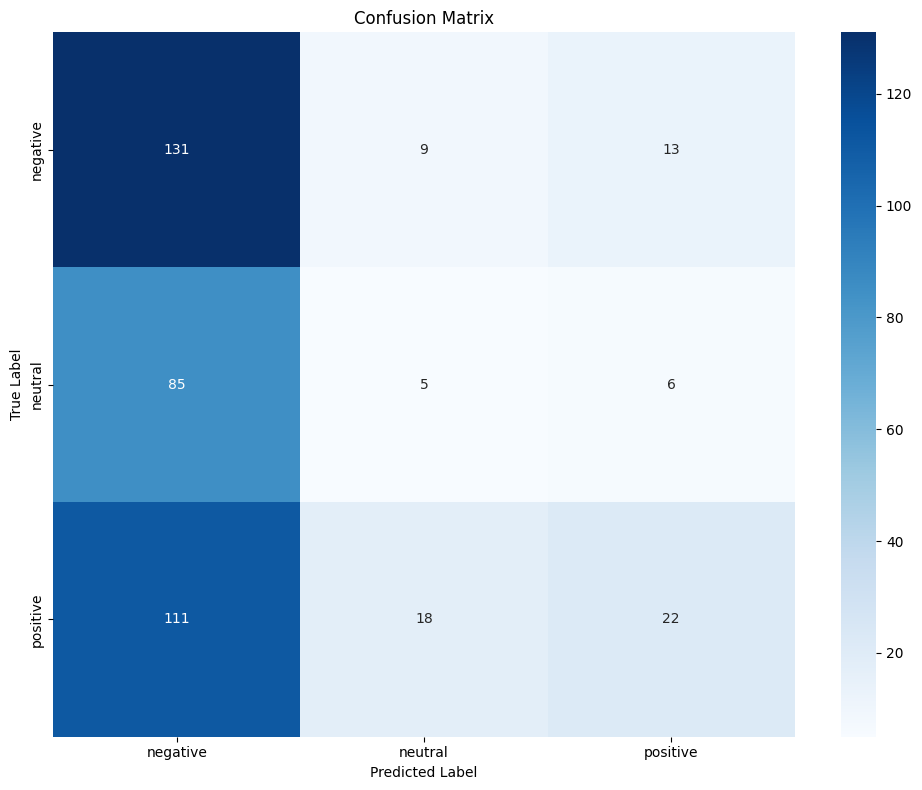


True Label Distribution:
  negative: 153 (38.2%)
  neutral: 96 (24.0%)
  positive: 151 (37.8%)

Predicted Label Distribution:
  negative: 327 (81.8%)
  neutral: 32 (8.0%)
  positive: 41 (10.2%)

Prediction Confidence Analysis:
  Mean confidence: 0.3726
  Median confidence: 0.3695
  Min confidence: 0.3356
  Max confidence: 0.4576


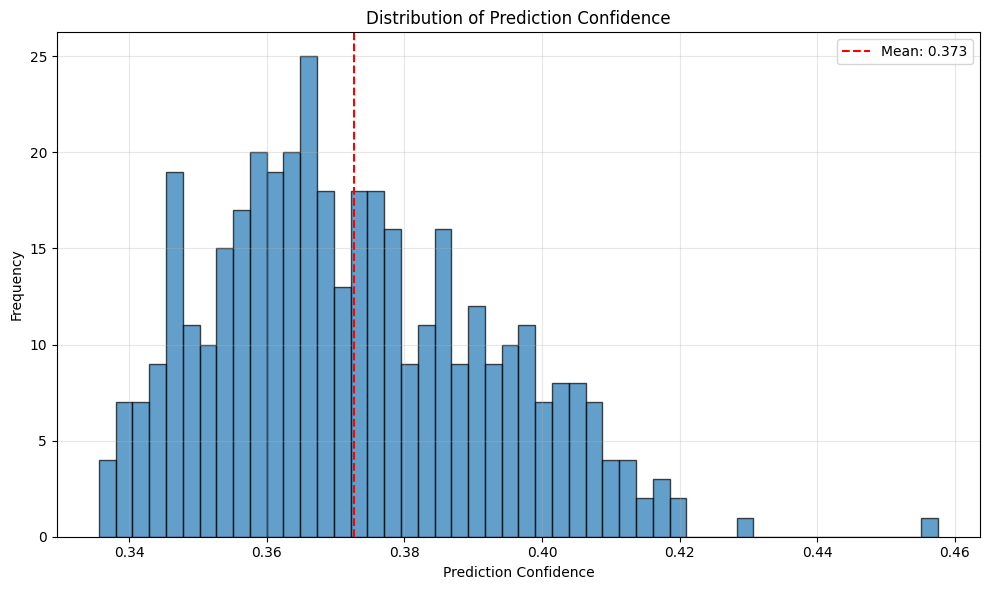


SCRATCH MODEL EVALUATION

COMPREHENSIVE EVALUATION
Accuracy: 0.3800
F1 Score (Macro): 0.2698
F1 Score (Weighted): 0.3070

Classification Report:
              precision    recall  f1-score   support

    negative       0.34      0.25      0.29       153
     neutral       0.00      0.00      0.00        96
    positive       0.40      0.75      0.52       151

    accuracy                           0.38       400
   macro avg       0.25      0.33      0.27       400
weighted avg       0.28      0.38      0.31       400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


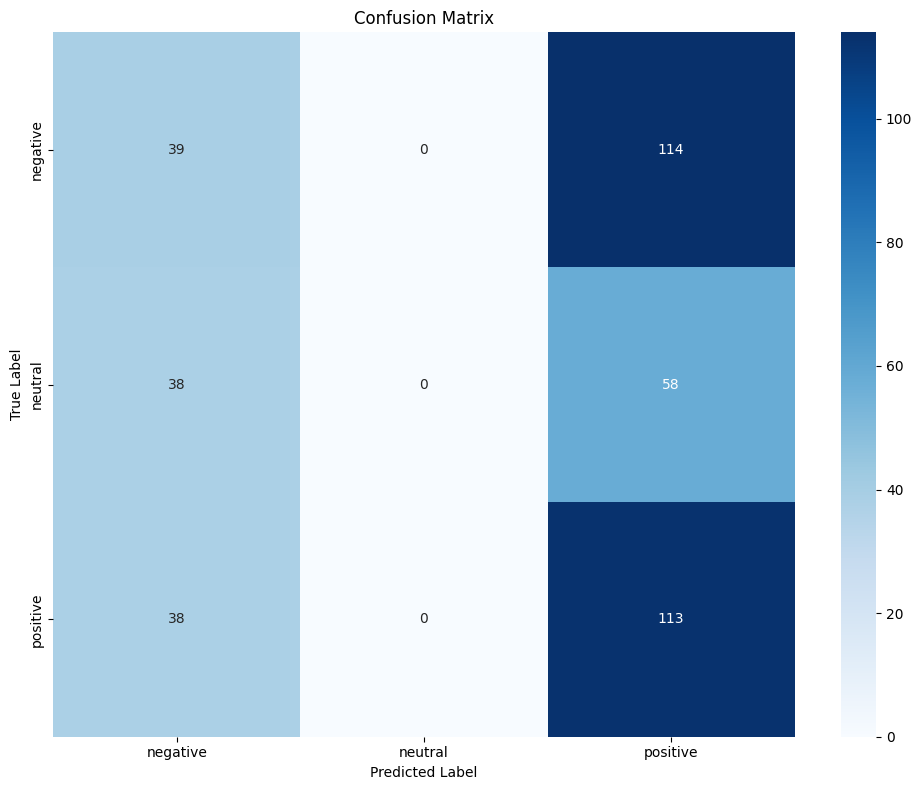


True Label Distribution:
  negative: 153 (38.2%)
  neutral: 96 (24.0%)
  positive: 151 (37.8%)

Predicted Label Distribution:
  negative: 115 (28.7%)
  neutral: 0 (0.0%)
  positive: 285 (71.2%)

Prediction Confidence Analysis:
  Mean confidence: 0.3887
  Median confidence: 0.3881
  Min confidence: 0.3499
  Max confidence: 0.4585


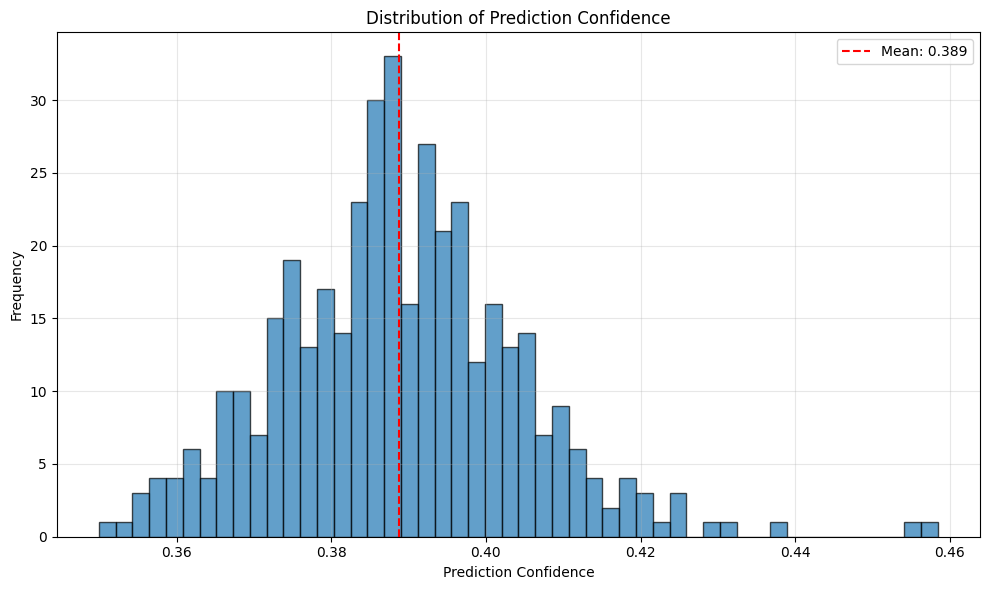


TESTING SUMMARY
Test 1 (Forward Propagation Match): FAIL
Test 2 (Scratch Consistency): PASS

Keras Model Performance:
  Accuracy: 0.3950
  F1 (Macro): 0.2844

Scratch Model Performance:
  Accuracy: 0.3800
  F1 (Macro): 0.2698
  Performance Difference: 0.0150


In [26]:
def test_forward_propagation(keras_model, scratch_model, X_test, y_test, vectorizer):
    """Test 1: Compare forward propagation between Keras model and scratch implementation"""
    print("=" * 60)
    print("TEST 1: Forward Propagation Comparison")
    print("=" * 60)

    # test data
    X_test_full = X_test
    y_test_full = y_test_numeric

    # preprocess text data
    X_test_seq = vectorizer(X_test_full)

    # keras model prediction
    print("Running Keras model prediction...")
    keras_pred = keras_model.predict(X_test_seq, verbose=0)

    # scratch model prediction
    print("Running scratch model prediction...")
    scratch_pred = scratch_model.predict(X_test_full)

    # compare predictions
    mse = np.mean((keras_pred - scratch_pred) ** 2)
    max_diff = np.max(np.abs(keras_pred - scratch_pred))
    mean_abs_diff = np.mean(np.abs(keras_pred - scratch_pred))

    print(f"Mean Squared Error: {mse:.8f}")
    print(f"Maximum Absolute Difference: {max_diff:.8f}")
    print(f"Mean Absolute Difference: {mean_abs_diff:.8f}")

    # check if predictions are close enough
    if mse < 1e-6:
        print("Forward propagation matches between Keras and scratch models")
    else:
        print("Forward propagation differs significantly between Keras and scratch models")

    # some sample predictions
    print(f"\nSample predictions (first 5):")
    print("Keras predictions:")
    for i in range(min(5, len(keras_pred))):
        true_label = reverse_label_mapping[y_test_full[i]]  # Get true label text
        pred_label_idx = np.argmax(keras_pred[i])  # Get predicted class index
        pred_label = reverse_label_mapping[pred_label_idx]  # Get predicted label text
        print(f"  Sample {i}:")
        print(f"    True label: {true_label}")
        print(f"    Predicted: {pred_label} (confidence: {np.max(keras_pred[i]):.2f})")
        print(f"    Probabilities: {[f'{p:.4f}' for p in keras_pred[i]]}")

    print("\nScratch predictions:")
    for i in range(min(5, len(scratch_pred))):
        true_label = reverse_label_mapping[y_test_full[i]]  # Get true label text
        pred_label_idx = np.argmax(scratch_pred[i])  # Get predicted class index
        pred_label = reverse_label_mapping[pred_label_idx]  # Get predicted label text
        print(f"  Sample {i}:")
        print(f"    True label: {true_label}")
        print(f"    Predicted: {pred_label} (confidence: {np.max(scratch_pred[i]):.2f})")
        print(f"    Probabilities: {[f'{p:.4f}' for p in scratch_pred[i]]}")

    return mse < 1e-6

def test_scratch_consistency(scratch_model, X_test, y_test):
    """Test 2: Compare scratch model with and without backpropagation"""
    print("\n" + "=" * 60)
    print("TEST 2: Scratch Model Consistency (Forward vs Forward+Backward)")
    print("=" * 60)

    # test data
    X_test_full = X_test
    y_test_full = y_test_numeric

    # forward pass only
    print("Running forward pass only...")
    pred_forward_only = scratch_model.predict(X_test_full)

    # forward pass followed by backward pass
    print("Running forward + backward pass...")
    pred_with_backward = scratch_model.forward(X_test_full)

    # simulate backward pass (doesn't change forward result)
    dummy_grad = np.ones_like(pred_with_backward)
    gradients = scratch_model.backward(dummy_grad, y_test_full)

    # forward pass again to check consistency
    pred_after_backward = scratch_model.predict(X_test_full)

    # compare predictions
    mse1 = np.mean((pred_forward_only - pred_with_backward) ** 2)
    mse2 = np.mean((pred_forward_only - pred_after_backward) ** 2)

    print(f"MSE (forward vs forward+backward): {mse1:.8f}")
    print(f"MSE (forward vs after backward): {mse2:.8f}")

    if mse1 < 1e-10 and mse2 < 1e-10:
        print("Scratch model is consistent")
        print("Forward pass results remain unchanged after backward pass")
    else:
        print("Scratch model shows inconsistency")

    print(f"Backward pass computed gradients for {len(gradients)} layers")

    # some sample predictions
    print(f"\nSample predictions (first 5):")
    print("Forward predictions:")
    for i in range(min(5, len(pred_forward_only))):
        true_label = reverse_label_mapping[y_test_full[i]]  # Get true label text
        pred_label_idx = np.argmax(pred_forward_only[i])  # Get predicted class index
        pred_label = reverse_label_mapping[pred_label_idx]  # Get predicted label text
        print(f"  Sample {i}:")
        print(f"    True label: {true_label}")
        print(f"    Predicted: {pred_label} (confidence: {np.max(pred_forward_only[i]):.2f})")
        print(f"    Probabilities: {[f'{p:.4f}' for p in pred_forward_only[i]]}")

    print("\nForward + Backward predictions:")
    for i in range(min(5, len(pred_after_backward))):
        true_label = reverse_label_mapping[y_test_full[i]]  # Get true label text
        pred_label_idx = np.argmax(pred_after_backward[i])  # Get predicted class index
        pred_label = reverse_label_mapping[pred_label_idx]  # Get predicted label text
        print(f"  Sample {i}:")
        print(f"    True label: {true_label}")
        print(f"    Predicted: {pred_label} (confidence: {np.max(pred_after_backward[i]):.2f})")
        print(f"    Probabilities: {[f'{p:.4f}' for p in pred_after_backward[i]]}")

    return mse1 < 1e-10 and mse2 < 1e-10

def comprehensive_evaluation(model, X_test, y_test, vectorizer, label_mapping):
    """Comprehensive evaluation with confusion matrix and class distribution"""
    print("\n" + "=" * 60)
    print("COMPREHENSIVE EVALUATION")
    print("=" * 60)

    if isinstance(X_test[0], str):
        X_test_seq = vectorizer(X_test)
        predictions = model.predict(X_test_seq if hasattr(model, 'predict') else X_test)
    else:
        predictions = model.predict(X_test)

    # get predicted classes
    y_pred_classes = np.argmax(predictions, axis=1)

    # calculate metrics
    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

    accuracy = accuracy_score(y_test, y_pred_classes)
    f1_macro = f1_score(y_test, y_pred_classes, average='macro')
    f1_weighted = f1_score(y_test, y_pred_classes, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")

    # classification report
    reverse_label_mapping = {idx: label for label, idx in label_mapping.items()}
    target_names = [reverse_label_mapping[i] for i in range(len(label_mapping))]

    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=target_names))

    # confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # class distribution analysis
    print(f"\nTrue Label Distribution:")
    true_dist = np.bincount(y_test)
    for i, count in enumerate(true_dist):
        label_name = reverse_label_mapping[i]
        percentage = count / len(y_test) * 100
        print(f"  {label_name}: {count} ({percentage:.1f}%)")

    print(f"\nPredicted Label Distribution:")
    pred_dist = np.bincount(y_pred_classes)
    for i, count in enumerate(pred_dist):
        label_name = reverse_label_mapping[i]
        percentage = count / len(y_pred_classes) * 100
        print(f"  {label_name}: {count} ({percentage:.1f}%)")

    # prediction confidence analysis
    print(f"\nPrediction Confidence Analysis:")
    max_probs = np.max(predictions, axis=1)
    print(f"  Mean confidence: {np.mean(max_probs):.4f}")
    print(f"  Median confidence: {np.median(max_probs):.4f}")
    print(f"  Min confidence: {np.min(max_probs):.4f}")
    print(f"  Max confidence: {np.max(max_probs):.4f}")

    # plot confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(max_probs, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(max_probs), color='red', linestyle='--', label=f'Mean: {np.mean(max_probs):.3f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Confidence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.close('all')

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'predictions': predictions,
        'predicted_classes': y_pred_classes
    }

def run_all_tests():
    """Run all tests and evaluations"""
    print("STARTING COMPREHENSIVE TESTING...")
    print("=" * 80)

    # load models
    try:
        keras_model = load_model('best_rnn_model.h5')
        print("Keras model loaded successfully")
    except:
        print("Failed to load Keras model. Please run the training code first.")
        return

    # create scratch model with backpropagation
    try:
        scratch_model = RNNModelFromScratch(
            'best_rnn_model.h5',
            'vectorizer_config.pkl',
            training_texts=X_train
        )
        print("Scratch model with backprop created successfully")
    except Exception as e:
        print(f"Failed to create scratch model: {e}")
        return

    # run test 1: forward propagation comparison
    test1_passed = test_forward_propagation(keras_model, scratch_model, X_test, y_test_numeric, vectorizer)

    # run test 2: scratch model consistency
    test2_passed = test_scratch_consistency(scratch_model, X_test, y_test_numeric)

    # comprehensive evaluation on keras model
    print("\n" + "=" * 60)
    print("KERAS MODEL EVALUATION")
    print("=" * 60)
    keras_results = comprehensive_evaluation(keras_model, X_test, y_test_numeric, vectorizer, label_mapping)

    # comprehensive evaluation on scratch model
    print("\n" + "=" * 60)
    print("SCRATCH MODEL EVALUATION")
    print("=" * 60)
    scratch_results = comprehensive_evaluation(scratch_model, X_test, y_test_numeric, vectorizer, label_mapping)

    # summary
    print("\n" + "=" * 80)
    print("TESTING SUMMARY")
    print("=" * 80)
    print(f"Test 1 (Forward Propagation Match): {'PASS' if test1_passed else 'FAIL'}")
    print(f"Test 2 (Scratch Consistency): {'PASS' if test2_passed else 'FAIL'}")
    print(f"\nKeras Model Performance:")
    print(f"  Accuracy: {keras_results['accuracy']:.4f}")
    print(f"  F1 (Macro): {keras_results['f1_macro']:.4f}")
    print(f"\nScratch Model Performance:")
    print(f"  Accuracy: {scratch_results['accuracy']:.4f}")
    print(f"  F1 (Macro): {scratch_results['f1_macro']:.4f}")

    performance_diff = abs(keras_results['accuracy'] - scratch_results['accuracy'])
    print(f"  Performance Difference: {performance_diff:.4f}")

    return {
        'test1_passed': test1_passed,
        'test2_passed': test2_passed,
        'keras_results': keras_results,
        'scratch_results': scratch_results,
        'performance_diff': performance_diff
    }

# == MAIN EXECUTION == #
if __name__ == "__main__":
    results = run_all_tests()

### Best Model - Unidirectional mode


Unidirectional
Epoch 1/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3594 - loss: 1.1177

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3819 - loss: 1.0932 - val_f1_score: 0.1940
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.3815 - loss: 1.0933 - val_accuracy: 0.3700 - val_loss: 1.0895
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4699 - loss: 1.0443 - val_f1_score: 0.1897
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.4675 - loss: 1.0463 - val_accuracy: 0.3400 - val_loss: 1.0967
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4480 - loss: 1.0470 - val_f1_score: 0.2762
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.4466 - loss: 1.0484 - val_accuracy: 0.3700 - val_loss: 1.0909
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3807 - loss: 1.0849 - val_f1_score: 0.2270
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.3799 - loss: 1.0847 - val_accuracy: 0.3900 - val_loss: 1.0871
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4073 - loss: 1.0722 - val_f1_score: 0.2606
8/8 ━━━━━━━━━━━━━━━━

Test Accuracy: 0.4100
Test Macro F1 Score: 0.3832
Best model - unidirectional test F1 Score: 0.3832
Best model - unidirectional saved to 'best_rnn_model_unidirectional.h5'
Creating unidirectional scratch model...


Adapting vectorizer with original training data...
Unidirectional scratch model created successfully

KERAS MODEL EVALUATION

COMPREHENSIVE EVALUATION
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Accuracy: 0.3575
F1 Score (Macro): 0.2014
F1 Score (Weighted): 0.2231

Classification Report:
              precision    recall  f1-score   support

    negative       0.33      0.03      0.05       153
     neutral       0.20      0.02      0.04        96
    positive       0.36      0.91      0.52       151

    accuracy                           0.36       400
   macro avg       0.30      0.32      0.20       400
weighted avg       0.31      0.36      0.22       400



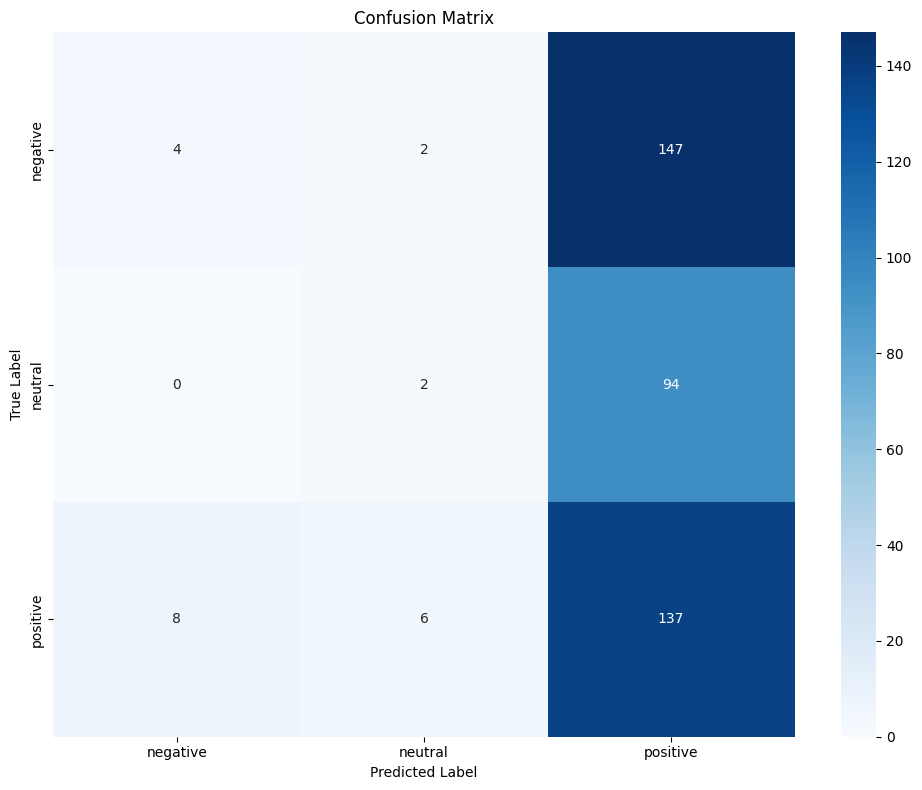


True Label Distribution:
  negative: 153 (38.2%)
  neutral: 96 (24.0%)
  positive: 151 (37.8%)

Predicted Label Distribution:
  negative: 12 (3.0%)
  neutral: 10 (2.5%)
  positive: 378 (94.5%)

Prediction Confidence Analysis:
  Mean confidence: 0.4280
  Median confidence: 0.4263
  Min confidence: 0.3448
  Max confidence: 0.5963


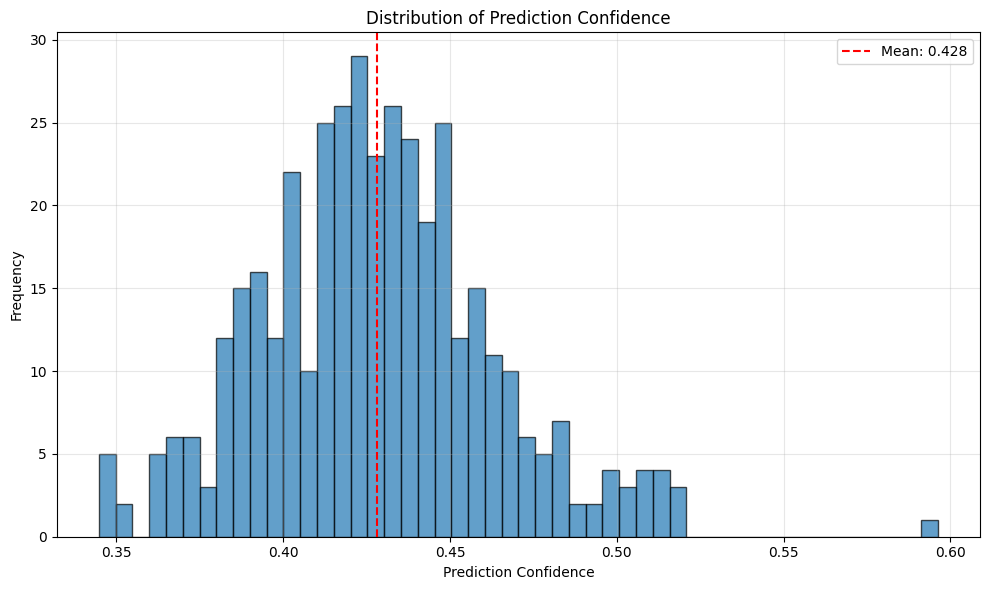


UNIDIRECTIONAL SCRATCH MODEL EVALUATION

COMPREHENSIVE EVALUATION
Accuracy: 0.3925
F1 Score (Macro): 0.3809
F1 Score (Weighted): 0.3865

Classification Report:
              precision    recall  f1-score   support

    negative       0.42      0.52      0.46       153
     neutral       0.29      0.43      0.34        96
    positive       0.53      0.25      0.33       151

    accuracy                           0.39       400
   macro avg       0.41      0.40      0.38       400
weighted avg       0.43      0.39      0.39       400



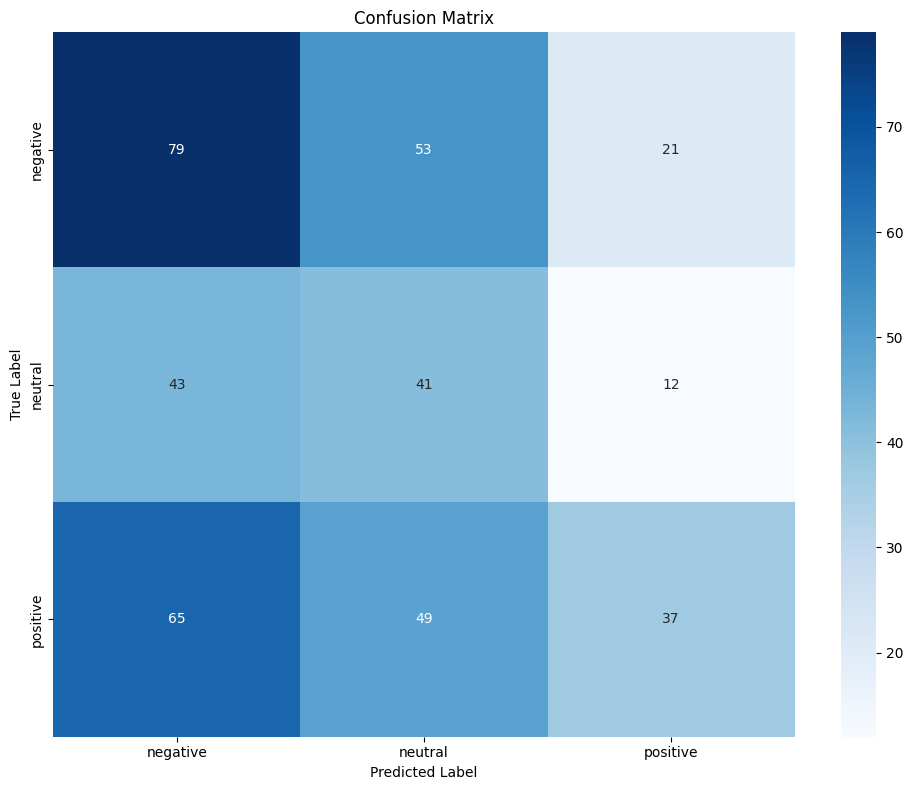


True Label Distribution:
  negative: 153 (38.2%)
  neutral: 96 (24.0%)
  positive: 151 (37.8%)

Predicted Label Distribution:
  negative: 187 (46.8%)
  neutral: 143 (35.8%)
  positive: 70 (17.5%)

Prediction Confidence Analysis:
  Mean confidence: 0.3992
  Median confidence: 0.3948
  Min confidence: 0.3351
  Max confidence: 0.5183


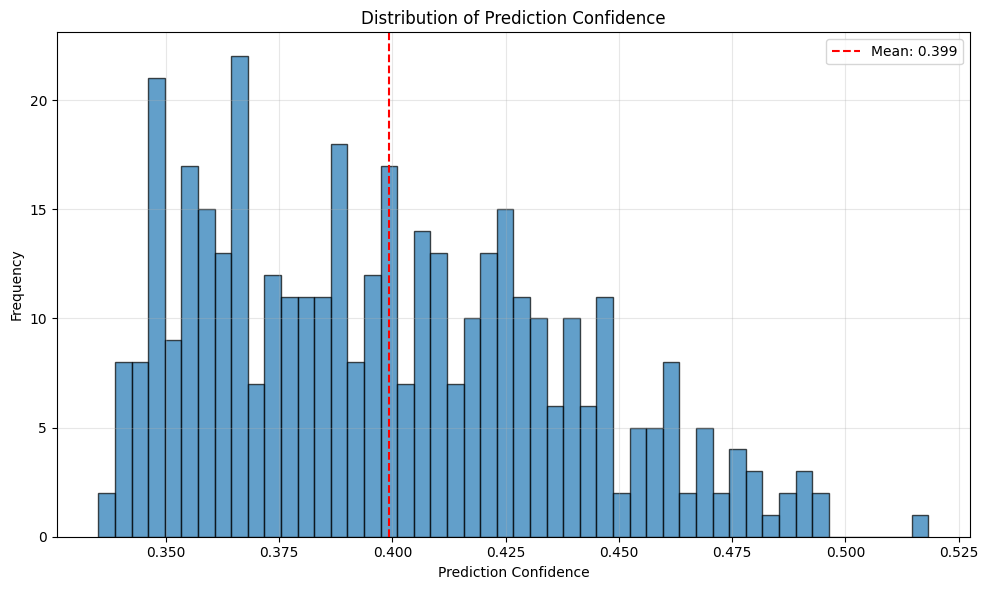


Unidirectional Keras Model Performance:
  Accuracy: 0.3575
  F1 (Macro): 0.2014

Unidirectional Scratch Model Performance:
  Accuracy: 0.3925
  F1 (Macro): 0.3809


In [33]:
def test_unidirectional_model():
    print("\n" + "=" * 60)
    print("Unidirectional")
    print("=" * 60)

    # THIS IS THE SAME AS THE BEST MODEL, BUT BIDIRECTIONAL == FALSE
    unidirectional_model = create_rnn_model(
        num_rnn_layers=2,
        rnn_units=[64,64],
        bidirectional=False
    )

    # train the best model
    history, f1_scores, test_f1 = train_and_evaluate_model(best_model, epochs=10)
    print(f"Best model - unidirectional test F1 Score: {test_f1:.4f}")
    # save the best model
    best_model.save('best_rnn_model_unidirectional.h5')
    print("Best model - unidirectional saved to 'best_rnn_model_unidirectional.h5'")

    # unidirectional scratch model from the saved model
    print("Creating unidirectional scratch model...")
    try:
        scratch_model_unidirectional = RNNModelFromScratch(
            'best_rnn_model_unidirectional.h5',
            'vectorizer_config.pkl',
            training_texts=X_train
        )
        print("Unidirectional scratch model created successfully")
    except Exception as e:
        print(f"Failed to create unidirectional scratch model: {e}")
        return False

    # comprehensive evaluation on unidirectional keras model
    print("\n" + "=" * 60)
    print("KERAS MODEL EVALUATION")
    print("=" * 60)
    unidirectional_keras_results = comprehensive_evaluation(unidirectional_model, X_test, y_test_numeric, vectorizer, label_mapping)

    # comprehensive evaluation on unidirectional scratch model
    print("\n" + "=" * 60)
    print("UNIDIRECTIONAL SCRATCH MODEL EVALUATION")
    print("=" * 60)
    unidirectional_scratch_results = comprehensive_evaluation(scratch_model_unidirectional, X_test, y_test_numeric, vectorizer, label_mapping)

    print(f"\nUnidirectional Keras Model Performance:")
    print(f"  Accuracy: {unidirectional_keras_results['accuracy']:.4f}")
    print(f"  F1 (Macro): {unidirectional_keras_results['f1_macro']:.4f}")
    print(f"\nUnidirectional Scratch Model Performance:")
    print(f"  Accuracy: {unidirectional_scratch_results['accuracy']:.4f}")
    print(f"  F1 (Macro): {unidirectional_scratch_results['f1_macro']:.4f}")


# == MAIN EXECUTION == #
if __name__ == "__main__":
    results = test_unidirectional_model()